In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [11]:
df = pd.read_excel('apps_event.xlsx')

In [12]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [4]:
df['event'].value_counts()

app_start      128618
search         122028
choose_item     94220
tap_basket      67897
purchase        29222
Name: event, dtype: int64

In [5]:
df['utm_source'].value_counts()

-                97782
vk_ads           67441
yandex-direct    67023
google_ads       63286
instagram_ads    59860
facebook_ads     51257
referal          35336
Name: utm_source, dtype: int64

# Retention rate

In [14]:
#Возьмём дату, когда пользователь впервые проявил активность
first_session_date_by_customers = df.groupby('device_id')['date'].min()
first_session_date_by_customers
first_session_date_by_customers.name = 'first_session_date'

In [16]:
visits = df.join(first_session_date_by_customers,on='device_id')

In [17]:
visits['cohort_lifetime'] = (visits['date'] - visits['first_session_date']).dt.days

In [18]:
visits

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,first_session_date,cohort_lifetime
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01,0
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,0
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01-01,0
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01,0
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01,0
...,...,...,...,...,...,...,...,...,...,...
441980,2020-01-15,tap_basket,NaN,ios,8700975,female,Moscow,vk_ads,2020-01-05,10
441981,2020-01-15,tap_basket,NaN,android,2531506,male,Saint-Petersburg,-,2020-01-10,5
441982,2020-01-15,tap_basket,NaN,ios,6525227,female,Moscow,-,2020-01-13,2
441983,2020-01-15,tap_basket,NaN,android,17844257,male,Saint-Petersburg,-,2020-01-11,4


In [19]:
df.query('date == "2020-01-01"').device_id.nunique()

4445

In [22]:
#Сгруппируем данные по когорте и lifetime
cohorts = visits.groupby(['first_session_date', 'cohort_lifetime']).agg({'device_id': 'nunique'}).reset_index()
cohorts

,first_session_date,cohort_lifetime,device_id
0,2020-01-01,0,4445
1,2020-01-01,1,1211
2,2020-01-01,2,1257
3,2020-01-01,3,1154
4,2020-01-01,4,1271
...,...,...,...
115,2020-01-13,1,644
116,2020-01-13,2,430
117,2020-01-14,0,6415
118,2020-01-14,1,660


In [23]:
#Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю
initial_users_count = cohorts[cohorts['cohort_lifetime']== 0][['first_session_date', 'device_id']]
initial_users_count = initial_users_count.rename(columns={'device_id': 'cohort_users'})

In [24]:
initial_users_count

,first_session_date,cohort_users
0,2020-01-01,4445
15,2020-01-02,3893
29,2020-01-03,2986
42,2020-01-04,2300
54,2020-01-05,2081
65,2020-01-06,1845
75,2020-01-07,1568
84,2020-01-08,1396
92,2020-01-09,1726
99,2020-01-10,16223


In [25]:
#Объединим данные по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count, on='first_session_date')

In [27]:
cohorts['retention'] = cohorts['device_id']/cohorts['cohort_users']

In [28]:
cohorts

,first_session_date,cohort_lifetime,device_id,cohort_users,retention
0,2020-01-01,0,4445,4445,1.000000
1,2020-01-01,1,1211,4445,0.272441
2,2020-01-01,2,1257,4445,0.282790
3,2020-01-01,3,1154,4445,0.259618
4,2020-01-01,4,1271,4445,0.285939
...,...,...,...,...,...
115,2020-01-13,1,644,5619,0.114611
116,2020-01-13,2,430,5619,0.076526
117,2020-01-14,0,6415,6415,1.000000
118,2020-01-14,1,660,6415,0.102884


In [29]:
retention_pivot = cohorts.pivot_table(index='first_session_date', columns='cohort_lifetime',
                                      values='retention', aggfunc='sum')
retention_pivot.round(3).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
first_session_date,,,,,,,,,,,,,,,
2020-01-01,1.0,0.272,0.283,0.26,0.286,0.262,0.246,0.261,0.255,0.3,0.299,0.276,0.269,0.256,0.241
2020-01-02,1.0,0.231,0.229,0.269,0.226,0.205,0.211,0.215,0.269,0.255,0.228,0.217,0.211,0.215,
2020-01-03,1.0,0.195,0.238,0.171,0.159,0.168,0.157,0.229,0.212,0.184,0.179,0.166,0.166,,
2020-01-04,1.0,0.217,0.166,0.138,0.149,0.143,0.205,0.189,0.173,0.164,0.148,0.142,,,
2020-01-05,1.0,0.184,0.136,0.136,0.136,0.194,0.174,0.148,0.143,0.127,0.135,,,,
2020-01-06,1.0,0.131,0.133,0.122,0.17,0.172,0.145,0.144,0.127,0.115,,,,,
2020-01-07,1.0,0.129,0.126,0.14,0.136,0.112,0.12,0.109,0.11,,,,,,
2020-01-08,1.0,0.156,0.185,0.162,0.147,0.12,0.117,0.112,,,,,,,
2020-01-09,1.0,0.274,0.221,0.162,0.147,0.125,0.118,,,,,,,,


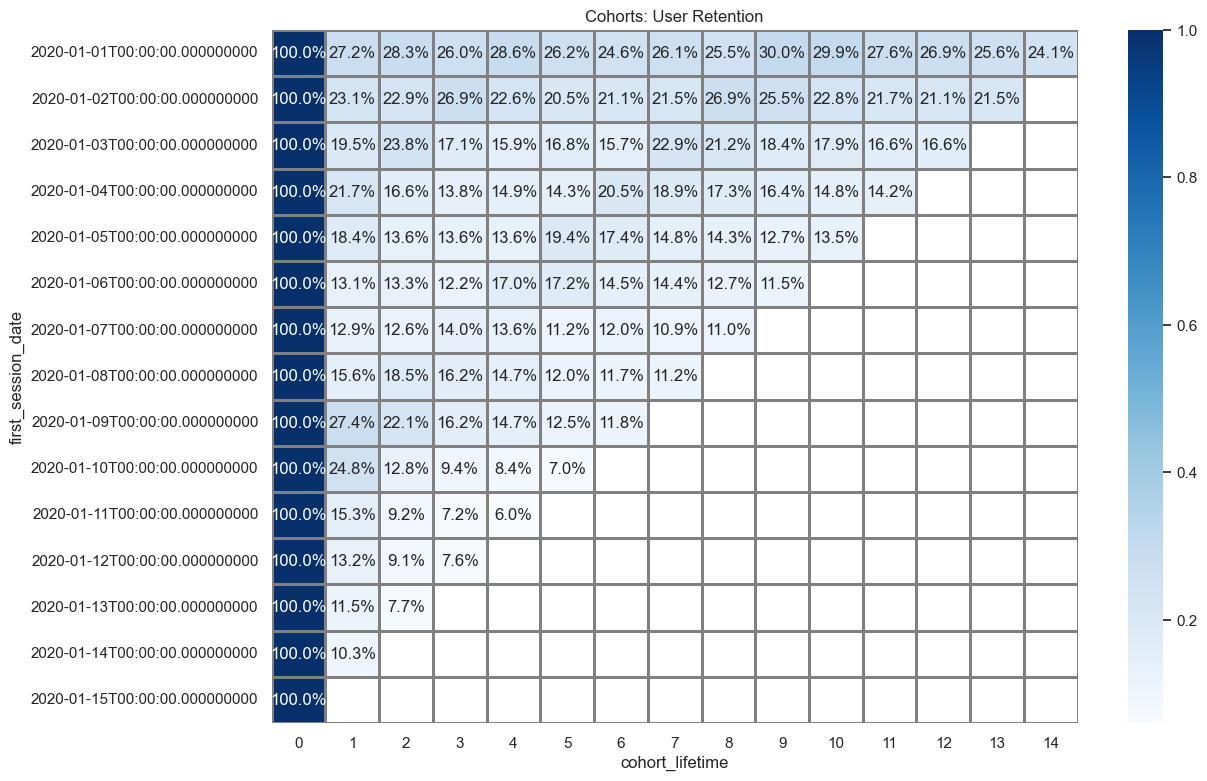

In [30]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap = 'Blues');